In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import Markdown, display
import statsmodels.formula.api as smf

In [2]:
#Load data
df = pd.read_csv('/Users/ellenwu/homework5-1/data/output/acs_medicaid.txt',delimiter='\t')

1. Plot the share of the adult population with direct purchase health insurance over time.

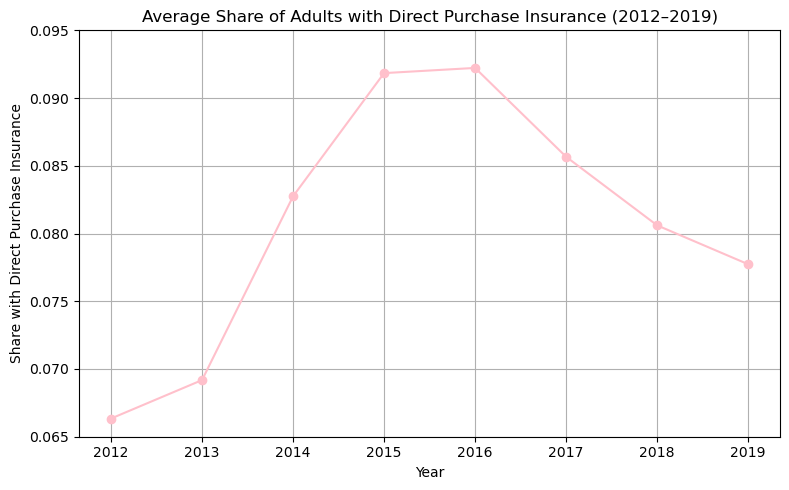

In [3]:
# Drop rows where adult population or direct insurance values are missing or zero
df = df[df['adult_pop'].notna() & df['ins_direct'].notna()]
df = df[df['adult_pop'] > 0]

# Calculate share of direct-purchase insurance
df['share_direct'] = df['ins_direct'] / df['adult_pop']

# Filter out any rows where the share is missing or invalid
df = df[df['share_direct'].notna() & df['share_direct'].apply(lambda x: x != float('inf'))]

# Group by year to calculate the average share
trend = df.groupby('year', as_index=False)['share_direct'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['share_direct'], marker='o', linestyle='-', color='pink')
plt.title("Average Share of Adults with Direct Purchase Insurance (2012–2019)")
plt.xlabel("Year")
plt.ylabel("Share with Direct Purchase Insurance")
plt.ylim(0, trend['share_direct'].max() * 1.1 if not trend['share_direct'].isna().all() else 0.05)
plt.grid(True)
plt.xticks(ticks=trend['year'], labels=trend['year'])
plt.ylim(0.065, 0.095)
plt.tight_layout()
plt.show()

2. Discuss the reduction in direct purchase health insurance in later years. Can you list a couple of policies that might have affected the success of the direct purchase insurance market?

In later years, the share of adults with direct-purchase health insurance declined after peaking during the initial rollout of the ACA exchanges. Two major policy changes likely contributed to this drop. First, the repeal of the individual mandate penalty in 2019 reduced the incentive for healthy individuals to purchase insurance, weakening risk pools. Second, the termination of cost-sharing reduction payments in 2017 led insurers to raise premiums, making plans less affordable for many. These shifts undermined the stability of the individual market and reduced participation.

3. Plot the share of the adult population with Medicaid over time.

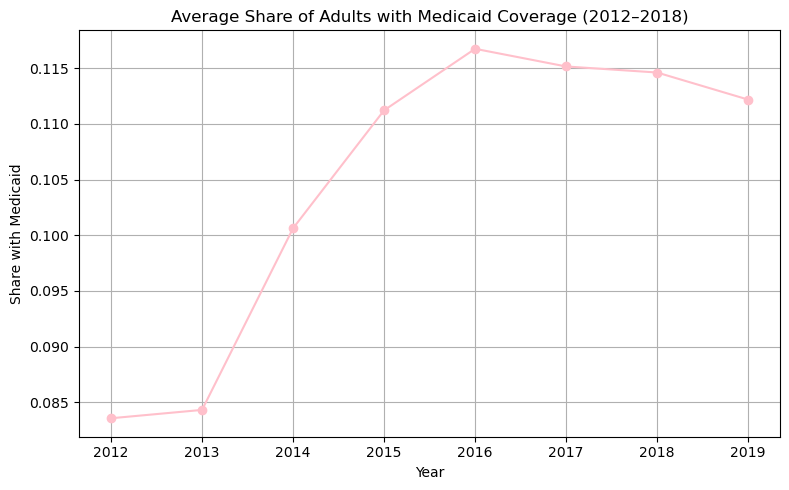

In [ ]:
# Calculate share of adult population with Medicaid
df['share_medicaid'] = df['ins_medicaid'] / df['adult_pop']

# Group by year and calculate average share
medicaid_trend = df.groupby('year', as_index=False)['share_medicaid'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(medicaid_trend['year'], medicaid_trend['share_medicaid'], marker='o', linestyle='-', color='Pink')
plt.title("Average Share of Adults with Medicaid Coverage (2012–2019)")
plt.xlabel("Year")
plt.ylabel("Share with Medicaid")
plt.grid(True)
plt.tight_layout()
plt.show()

4. Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not. Drop all states that expanded after 2014.

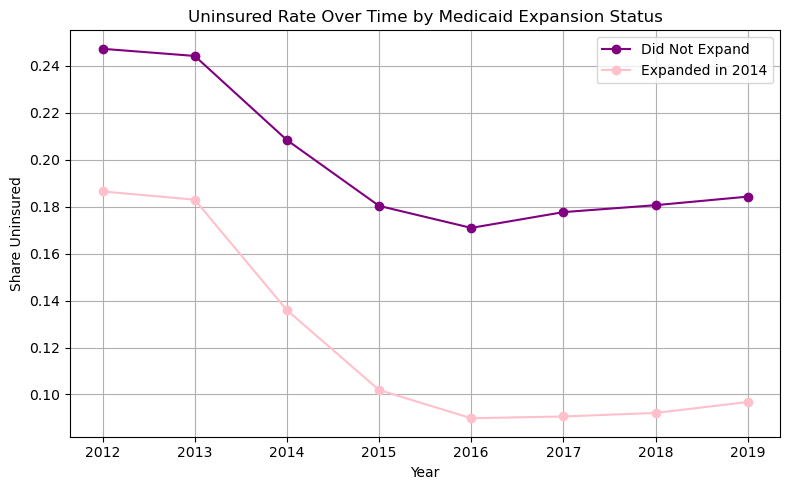

In [5]:
# Identify states that expanded in 2014 or never expanded
expansion_2014_states = df[df['expand_year'] == 2014]['State'].unique()
never_expanded_states = df[df['expand_ever'] == False]['State'].unique()

# Combine them into one list
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))

# Filter dataset
filtered_df = df[df['State'].isin(keep_states)].copy()

# Assign group labels explicitly
filtered_df['expansion_group'] = filtered_df['State'].apply(
    lambda x: 'Expanded in 2014' if x in expansion_2014_states else 'Did Not Expand'
)

# Group by year and expansion status, then average
uninsured_trend = (
    filtered_df.groupby(['year', 'expansion_group'])['uninsured']
    .sum()
    .div(filtered_df.groupby(['year', 'expansion_group'])['adult_pop'].sum())
    .reset_index(name='share_uninsured')
)

# Plot
plt.figure(figsize=(8, 5))

for label, grp in uninsured_trend.groupby('expansion_group'):
    color = 'pink' if label == 'Expanded in 2014' else 'purple'
    plt.plot(grp['year'], grp['share_uninsured'], marker='o', label=label, color=color)

plt.title("Uninsured Rate Over Time by Medicaid Expansion Status")
plt.xlabel("Year")
plt.ylabel("Share Uninsured")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

5. Calculate the average percent of uninsured individuals in 2012 and 2015, separately for expansion and non-expansion states. Present your results in a basic 2x2 DD table.

In [9]:
df["uninsured_rate"] = df["uninsured"] / df["adult_pop"]

# Filter for expansion in 2014 or never
reg_data = (
    df.copy()
    .loc[(df["expand_year"].isna()) | (df["expand_year"] == 2014)]
    .loc[df["year"].isin([2012, 2015])]
)

# Group and pivot the summary table
dd_table = (
    reg_data.groupby(["expand_ever", "year"])["uninsured_rate"]
    .mean()
    .reset_index()
    .pivot(index="expand_ever", columns="year", values="uninsured_rate")
    .rename(columns={2012: "Pre", 2015: "Post"})
    .reset_index()
)

# Label the groups
dd_table["Group"] = dd_table["expand_ever"].map({False: "Non-expansion", True: "Expansion"})
dd_table = dd_table[["Group", "Pre", "Post"]]

# Display markdown table
def display_markdown_table(df):
    from IPython.display import Markdown, display
    markdown = df.to_markdown(index=False)
    display(Markdown(markdown))

display_markdown_table(dd_table.round(3))

| Group         |   Pre |   Post |
|:--------------|------:|-------:|
| Non-expansion | 0.216 |  0.158 |
| Expansion     | 0.168 |  0.094 |

6. Estimate the effect of Medicaid expansion on the uninsurance rate using a standard DD regression estimator, again focusing only on states that expanded in 2014 versus those that never expanded.

In [47]:
reg_data = df.copy()
reg_data["post"] = (reg_data["year"] >= 2014).astype(int)
reg_data = reg_data[(reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)]

# Handle possible NaNs in expand_ever
reg_data = reg_data[reg_data["expand_ever"].notna()]
reg_data["expand_ever"] = reg_data["expand_ever"].astype(int)
reg_data["treat"] = reg_data["post"] * reg_data["expand_ever"]
reg_data["uninsured_rate"] = reg_data["uninsured"] / reg_data["adult_pop"]

# Step 2: Run OLS regression
model = smf.ols("uninsured_rate ~ post + expand_ever + treat", data=reg_data).fit()

# Step 3: Extract results
coefs = model.params
ses = model.bse
pvals = model.pvalues
n_obs = int(model.nobs)
r2 = model.rsquared

# Step 4: Format output table
def format_coef(val, se, p):
    stars = ""
    if p < 0.01:
        stars = "***"
    elif p < 0.05:
        stars = "**"
    elif p < 0.1:
        stars = "*"
    return f"{val:.3f}{stars} ({se:.3f})"

rows = [
    ["Post 2014", format_coef(coefs["post"], ses["post"], pvals["post"])],
    ["Expand", format_coef(coefs["expand_ever"], ses["expand_ever"], pvals["expand_ever"])],
    ["Post x Expand", format_coef(coefs["treat"], ses["treat"], pvals["treat"])],
    ["Num. Obs.", f"{n_obs}"],
    ["R2", f"{r2:.3f}"]
]

dd_table = pd.DataFrame(rows, columns=["", "Standard DD"])

# Step 5: Display as markdown
markdown = dd_table.to_markdown(index=False)
display(Markdown(markdown))

|               | Standard DD       |
|:--------------|:------------------|
| Post 2014     | -0.054*** (0.008) |
| Expand        | -0.046*** (0.009) |
| Post x Expand | -0.019* (0.010)   |
| Num. Obs.     | 352               |
| R2            | 0.506             |

7. Include state and year fixed effects in your estimates. Try using the lfe or fixest package to estimate this instead of directly including the fixed effects.

In [49]:
import statsmodels.formula.api as smf

# Prepare data
reg_data = df.copy()
reg_data["post"] = (reg_data["year"] >= 2014).astype(int)
reg_data["expand_ever"] = reg_data["expand_ever"].fillna(False).astype(int)
reg_data["treat"] = reg_data["post"] * reg_data["expand_ever"]
reg_data["uninsured_rate"] = reg_data["uninsured"] / reg_data["adult_pop"]
reg_data = reg_data[(reg_data["expand_year"].isna()) | (reg_data["expand_year"] == 2014)]

# Run OLS with State and Year fixed effects
model_twfe = smf.ols("uninsured_rate ~ post + expand_ever + treat + C(State) + C(year)", data=reg_data).fit()

# Extract results for display
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

def format_coef(val, se, p):
    stars = ""
    if p < 0.01:
        stars = "***"
    elif p < 0.05:
        stars = "**"
    elif p < 0.1:
        stars = "*"
    return f"{val:.3f}{stars} ({se:.3f})"

rows = [
    ["Post 2014", format_coef(model_twfe.params['post'], model_twfe.bse['post'], model_twfe.pvalues['post'])],
    ["Expand", format_coef(model_twfe.params['expand_ever'], model_twfe.bse['expand_ever'], model_twfe.pvalues['expand_ever'])],
    ["Post x Expand", format_coef(model_twfe.params['treat'], model_twfe.bse['treat'], model_twfe.pvalues['treat'])],
    ["Num. Obs.", f"{int(model_twfe.nobs)}"],
    ["R2", f"{model_twfe.rsquared:.3f}"]
]

# Build and display table
results_table = pd.DataFrame(rows, columns=["", "TWFE"])
display(Markdown(results_table.to_markdown(index=False)))

|               | TWFE              |
|:--------------|:------------------|
| Post 2014     | -0.045*** (0.003) |
| Expand        | -0.035*** (0.006) |
| Post x Expand | -0.022*** (0.004) |
| Num. Obs.     | 360               |
| R2            | 0.947             |

8. Repeat the analysis in question 7 but include all states (even those that expanded after 2014). Are your results different? If so, why?

In [46]:
# Copy full dataset
df_all = df.copy()

# Treatment: 1 if a state ever expanded Medicaid
df_all['treatment'] = df_all['expand_ever'].fillna(0).astype(int)

# Post: 1 if year >= expansion year (if applicable)
df_all['post'] = (df_all['year'] >= df_all['expand_year']).astype(int)

# DiD interaction
df_all['interaction'] = df_all['treatment'] * df_all['post']

# Outcome: uninsurance rate
df_all['uninsured_rate'] = df_all['uninsured'] / df_all['adult_pop']

# Drop missing or malformed data
df_all = df_all.dropna(subset=['uninsured_rate', 'interaction', 'State', 'year'])

# Estimate DiD with fixed effects using categorical variables
model_all = smf.ols("uninsured_rate ~ interaction + C(State) + C(year)", data=df_all).fit()

# Extract ATE and print only that
ate = model_all.params['interaction']
se = model_all.bse['interaction']
pval = model_all.pvalues['interaction']

print("\nQ8: DiD Regression with All States and Years Included (w/ FE)")
print(f"Estimated ATE (All States, w/ FE): {ate:.4f}")
print(f"Standard Error: {se:.4f}, p-value: {pval:.4f}")


Q8: DiD Regression with All States and Years Included (w/ FE)
Estimated ATE (All States, w/ FE): -0.0238
Standard Error: 0.0029, p-value: 0.0000


In [ ]:


# Copy data
reg_data2 = df.copy()

# Create treatment indicator (1 if year >= expansion year)
reg_data2["treat"] = 0
reg_data2.loc[
    (reg_data2["year"] >= reg_data2["expand_year"]) & (reg_data2["expand_year"].notna()),
    "treat"
] = 1

# Create outcome variable if needed
reg_data2["uninsured_rate"] = reg_data2["uninsured"] / reg_data2["adult_pop"]

# Drop rows with missing values in key columns
reg_data2 = reg_data2.dropna(subset=["treat", "uninsured_rate", "State", "year"])

# Run regression with state and year fixed effects
twfe_model = smf.ols("uninsured_rate ~ treat + C(State) + C(year)", data=reg_data2).fit()

# Extract results
coefs = twfe_model.params
ses = twfe_model.bse
pvals = twfe_model.pvalues
r2 = twfe_model.rsquared
n_obs = int(twfe_model.nobs)

# Format for markdown table
def format_coef(val, se, p):
    if p < 0.01:
        stars = "***"
    elif p < 0.05:
        stars = "**"
    elif p < 0.1:
        stars = "*"
    else:
        stars = ""
    return f"{val:.3f}{stars} ({se:.3f})"

# Build results table
rows = []
rows.append(["Time-varying Treat", format_coef(coefs['treat'], ses['treat'], pvals['treat'])])
rows.append(["Num. Obs.", f"{n_obs}"])
rows.append(["R2", f"{r2:.3f}"])

results_table = pd.DataFrame(rows, columns=["", "Time-varying Treatment"])

# Display markdown table
def display_markdown_table(df):
    display(Markdown(df.to_markdown(index=False)))

display_markdown_table(results_table)

|                    | Time-varying Treatment   |
|:-------------------|:-------------------------|
| Time-varying Treat | -0.024*** (0.003)        |
| Num. Obs.          | 416                      |
| R2                 | 0.946                    |

In [50]:
reg_data2 = df.copy()
reg_data2["treat"] = 0
reg_data2.loc[
    (reg_data2["year"] >= reg_data2["expand_year"]) & reg_data2["expand_year"].notna(),
    "treat"
] = 1
reg_data2["uninsured_rate"] = reg_data2["uninsured"] / reg_data2["adult_pop"]

# Run TWFE with clustered standard errors by State
model = smf.ols("uninsured_rate ~ treat + C(State) + C(year)", data=reg_data2).fit(
    cov_type='cluster', cov_kwds={'groups': reg_data2['State']}
)

# Extract values
coef = model.params['treat']
se = model.bse['treat']
pval = model.pvalues['treat']
n_obs = int(model.nobs)
r2 = model.rsquared

# Format stars
stars = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.1 else ''
coef_fmt = f"{coef:.3f}{stars} ({se:.3f})"

# Build and display table
import pandas as pd
from IPython.display import Markdown, display

results_table = pd.DataFrame([
    ["Time-varying Treat", coef_fmt],
    ["Num. Obs.", f"{n_obs}"],
    ["R2", f"{r2:.3f}"]
], columns=["", "Time-varying Treatment"])

display(Markdown(results_table.to_markdown(index=False)))


|                    | Time-varying Treatment   |
|:-------------------|:-------------------------|
| Time-varying Treat | -0.024*** (0.006)        |
| Num. Obs.          | 416                      |
| R2                 | 0.946                    |

9. Provide an “event study” graph showing the effects of Medicaid expansion in each year. Use the specification that includes state and year fixed effects, limited to states that expanded in 2014 or never expanded.

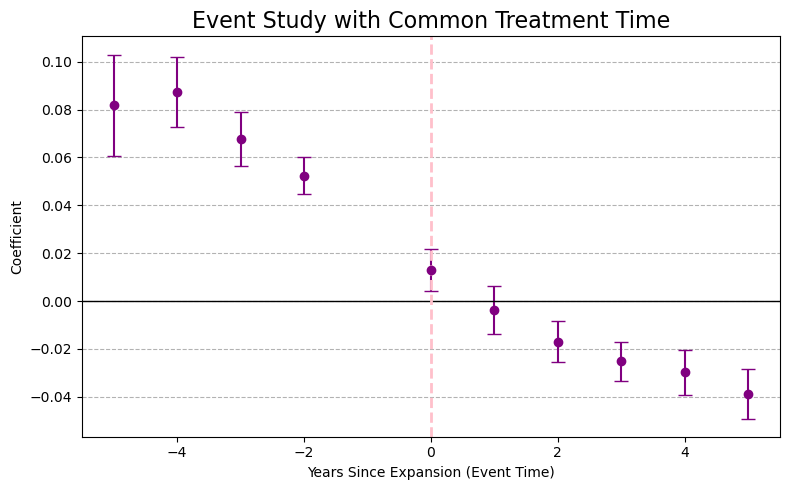

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Step 1: Setup and create event_time
es_data = df.copy()
es_data['event_time'] = es_data['year'] - es_data['expand_year']
es_data = es_data[(es_data['event_time'] >= -5) & (es_data['event_time'] <= 5)]
es_data = es_data[es_data['event_time'] != -1]  # drop reference year

# Step 2: Create dummy variables with valid names
for i in range(-5, 6):
    if i == -1:
        continue  # skip reference
    safe_name = f'event_m{abs(i)}' if i < 0 else f'event_p{i}'
    es_data[safe_name] = (es_data['event_time'] == i).astype(int)

# Step 3: Add outcome
es_data['uninsured_rate'] = es_data['uninsured'] / es_data['adult_pop']

# Step 4: Build regression formula
event_vars = [f'event_m{abs(i)}' if i < 0 else f'event_p{i}' for i in range(-5, 6) if i != -1]
formula = 'uninsured_rate ~ ' + ' + '.join(event_vars) + ' + C(State) + C(year)'

# Step 5: Run regression
event_model = smf.ols(formula=formula, data=es_data).fit()

# Step 6: Extract coefficients and CIs
coefs = event_model.params[event_vars]
errors = event_model.bse[event_vars]

# Convert back to event years for plotting
event_years = [
    -int(var.replace('event_m', '')) if 'event_m' in var else int(var.replace('event_p', ''))
    for var in event_vars
]

# Step 7: Plot
plt.figure(figsize=(8, 5))
plt.errorbar(event_years, coefs.values, yerr=1.96 * errors.values,
             fmt='o', capsize=5, color='purple')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='pink', linestyle='--', linewidth=2)
plt.title("Event Study with Common Treatment Time", fontsize=16)
plt.xlabel("Years Since Expansion (Event Time)")
plt.ylabel("Coefficient")
plt.grid(axis='y', linestyle='--', color='gray', alpha=0.6)
plt.tight_layout()
plt.show()

10. Repeat part 9 but again include states that expanded after 2014. Note: this is tricky…you need to put all states onto “event time” to create this graph.

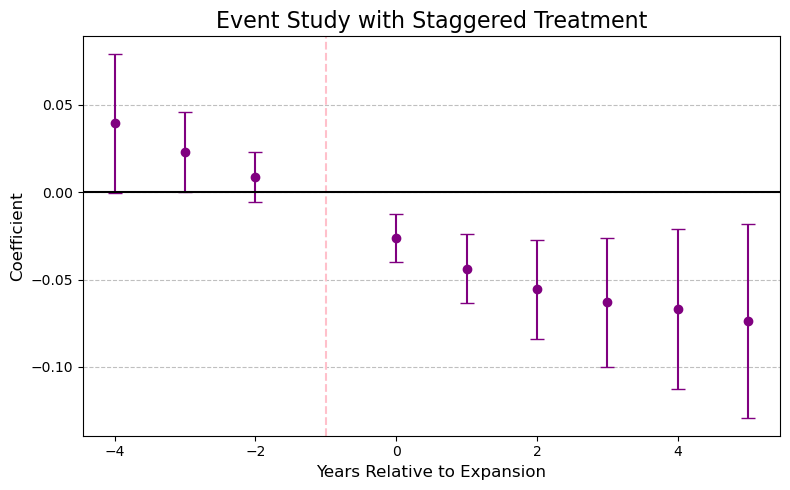

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Step 1: Create relative year (event time)
reg_data2 = df.copy()
reg_data2["relative_year"] = (reg_data2["year"] - reg_data2["expand_year"]).fillna(np.inf)
reg_data2 = reg_data2[reg_data2["relative_year"] != np.inf]  # Keep only states with expansion year
reg_data2["relative_year"] = reg_data2["relative_year"].clip(lower=-4, upper=5)
reg_data2["uninsured_rate"] = reg_data2["uninsured"] / reg_data2["adult_pop"]

# Step 2: Create event dummies
for yr in range(-4, 6):  # -4 to 5
    if yr == -1:
        continue  # reference category
    colname = f"event_m{abs(yr)}" if yr < 0 else f"event_p{yr}"
    reg_data2[colname] = (reg_data2["relative_year"] == yr).astype(int)

# Step 3: Run regression (with State + year FE)
event_vars = [f"event_m{abs(i)}" if i < 0 else f"event_p{i}" for i in range(-4, 6) if i != -1]
formula = f"uninsured_rate ~ {' + '.join(event_vars)} + C(State) + C(year)"
event_model = smf.ols(formula=formula, data=reg_data2).fit()

# Step 4: Extract coefficients and SEs
coefs = event_model.params[event_vars]
errors = event_model.bse[event_vars]

# Step 5: Convert names to relative years for x-axis
event_years = [-int(var.replace('event_m', '')) if 'event_m' in var else int(var.replace('event_p', '')) for var in event_vars]

# Step 6: Plot
plt.figure(figsize=(8, 5))
plt.errorbar(event_years, coefs, yerr=1.96 * errors, fmt='o', color='purple', capsize=5)
plt.axvline(x=-1, color="pink", linestyle="--")
plt.axhline(y=0, color="black", linestyle="-")
plt.title("Event Study with Staggered Treatment", fontsize=16)
plt.ylabel("Coefficient", fontsize=12)
plt.xlabel("Years Relative to Expansion", fontsize=12)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()